In [1]:
# data source: https://ceb.nlm.nih.gov/repositories/malaria-datasets/
# The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.
%reset -f

from keras.models import Sequential # to initialize CNN as a sequence of layers
from keras.layers import Convolution2D # for convolutional operations
from keras.layers import MaxPooling2D # for pooling operations
from keras.layers import Flatten # to flatten stacked feature maps into input layer
from keras.layers import Dense # to build fully-connected layers in a traditional neural network
from keras.layers import Dropout # to build a dropout layer(s); helps prevent overfitting
from keras.layers import BatchNormalization # to avoid internal covariate shift and speed up training

import numpy as np
np.random.seed(123)

Using TensorFlow backend.


In [2]:
##### set some hyperparameters
num_epochs = 10
batchsize = 32
rescaled_size = 64
num_filters = 32

In [3]:
##### part 1: building the CNN

In [4]:
### initialize the CNN
classifier = Sequential()

In [5]:
### step 1: add a convolution layer to the CNN
classifier.add(Convolution2D(filters=num_filters,
                             kernel_size=(3,3), # each kernel has a 3x3 receptive field
                             padding='same', # spatial dimensions of input image and feature map are the same
                             input_shape=(rescaled_size, rescaled_size, 3), # each input image has width=height, and 3 color channels
                             strides=(1,1), # stride 1 pixel at a time, along the width and height
                             activation='relu')) # apply ReLU activation function to the conv layer element-wise

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
### step 2: add a pooling layer to the CNN
classifier.add(MaxPooling2D(pool_size=(2,2), # pooling kernel has a 2x2 receptive field
                            strides=(2,2))) # stride 2 pixels at a time, along the width and height

In [7]:
### step 3: add a batch normalization layer to the CNN
#classifier.add(BatchNormalization())

In [8]:
### step 4: repeat steps 1 to 3 for a deep CNN
classifier.add(Convolution2D(filters=num_filters,
                             kernel_size=(3,3), # each kernel has a 3x3 receptive field
                             padding='same', # spatial dimensions of input image and feature map are the same
                             strides=(1,1), # stride 1 pixel at a time, along the width and height
                             activation='relu')) # apply ReLU activation function to the conv layer element-wise

classifier.add(MaxPooling2D(pool_size=(2,2), # pooling kernel has a 2x2 receptive field
                            strides=(2,2))) # stride 2 pixels at a time, along the width and height

#classifier.add(BatchNormalization())

In [9]:
### step 5: flatten the pooled feature maps into a vector of neurons (to be used as an input layer in a classic NN)
classifier.add(Flatten())

In [10]:
### step 6: fully connect the input layer to a hidden layer and output layer (classic NN)
#classifier.add(Dropout(0.5)) # dropout layer (with 50% probability of shutting down any given neuron) prevents overfitting

classifier.add(Dense(units=128, # 128 neurons in the hidden layer
                     activation='relu'))

#classifier.add(Dropout(0.5)) # dropout layer (with 50% probability of shutting down any given neuron) prevents overfitting

classifier.add(Dense(units=1, # classification problem is binary
                     activation='sigmoid')) # if classification problem was multiclass, we'd use softmax

In [11]:
### compile the CNN
classifier.compile(optimizer='adam', # stochastic gradient descent algorithm (to optimize the weights)
                   loss='binary_crossentropy',
                   metrics=['accuracy']) # alternative: crossentropy

In [12]:
##### part 2: fitting the CNN to the training set

In [13]:
### prevent overfitting by augmenting the number of images with transformed (e.g. zoomed, sheared) versions of those images
from keras.preprocessing.image import ImageDataGenerator

import os
os.chdir('D:\cell_images')

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size=(rescaled_size,rescaled_size), # all images will be resized to 64x64 pixels
                                                 batch_size=batchsize, # weights are updated every time batchsize images have been fed into the CNN
                                                 class_mode='binary') # 'categorical' if multiclass classification

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size=(rescaled_size,rescaled_size),
                                            batch_size=batchsize,
                                            class_mode='binary')

Found 17558 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [14]:
### train model
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = np.ceil(17558/batchsize),
                                   epochs = num_epochs, # number of times you want to feed all the training images into the CNN
                                   validation_data = test_set,
                                   validation_steps = np.ceil(10000/batchsize))

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
549/549 [==============================] - 34s 63ms/step - loss: 0.4681 - acc: 0.7807 - val_loss: 0.8378 - val_acc: 0.8744
Epoch 2/10
549/549 [==============================] - 32s 58ms/step - loss: 0.2417 - acc: 0.9274 - val_loss: 0.3885 - val_acc: 0.8349
Epoch 3/10
549/549 [==============================] - 32s 58ms/step - loss: 0.1695 - acc: 0.9479 - val_loss: 0.3195 - val_acc: 0.9073
Epoch 4/10
549/549 [==============================] - 32s 58ms/step - loss: 0.1447 - acc: 0.9553 - val_loss: 0.2172 - val_acc: 0.9205
Epoch 5/10
549/549 [==============================] - 32s 58ms/step - loss: 0.1358 - acc: 0.9574 - val_loss: 0.3062 - val_acc: 0.9075
Epoch 6/10
549/549 [==============================] - 32s 58ms/step - loss: 0.1266 - acc: 0.9604 - val_loss: 0.2782 - val_acc: 0.9126
Epoch 7/10
549/549 [==============================] - 32s 58ms/step - loss: 0.1191 - acc: 0.9624 - val_loss: 0.2287 - val_acc: 0.9136
Epoch 8/10
549

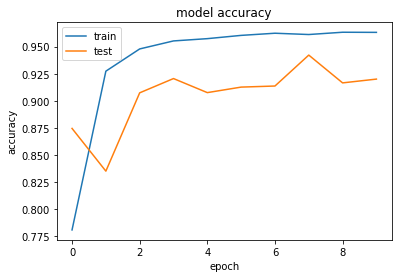

In [21]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
### save model
#classifier.save('flowers - model.h5')

### load model
#from keras.models import load_model
#classifier = load_model('flowers - model.h5')

In [17]:
##### part 3: fitting DenseNet121 to the training set

In [18]:
# ### set up DenseNet121
# from keras.applications import DenseNet121

# classifier = DenseNet121(
#     weights=None, 
#     include_top=True, 
#     classes=1,
#     input_shape=(rescaled_size, rescaled_size, 3)
# )

# classifier.compile(optimizer='adam', # stochastic gradient descent algorithm (to optimize the weights)
#                    loss='binary_crossentropy',
#                    metrics=['accuracy']) # alternative: crossentropy

In [19]:
# ### prepare data generators
# from keras.preprocessing.image import ImageDataGenerator

# import os
# os.chdir('D:\cell_images')

# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# training_set = train_datagen.flow_from_directory('training_set',
#                                                  target_size=(rescaled_size,rescaled_size), # all images will be resized to 64x64 pixels
#                                                  batch_size=batchsize, # weights are updated every time batchsize images have been fed into the CNN
#                                                  class_mode='binary') # 'categorical' if multiclass classification

# test_set = test_datagen.flow_from_directory('test_set',
#                                             target_size=(rescaled_size,rescaled_size),
#                                             batch_size=batchsize,
#                                             class_mode='binary')

In [20]:
# ### train model
# classifier.fit_generator(training_set,
#                          steps_per_epoch = np.ceil(17558/batchsize),
#                          epochs = num_epochs, # number of times you want to feed all the training images into the CNN
#                          validation_data = test_set,
#                          validation_steps = np.ceil(10000/batchsize))